# **0. 루브릭**

| 평가문항 | 상세기준 |
|----------|-----------|
| 1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다. | KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다. |
| 2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다. | 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다. |
| 3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다. | 테스트 수행결과 90% 이상의 정확도를 보였다. |


# **1. 실험하기**

**object detection 모델**을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 보겠습니다.

In [ ]:
# google drive 마운트하기
from google.colab import drive
drive.mount('/content/drive')

## **1. 자율주행 보조장치**

### **(1) KITTI 데이터셋**

카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 합니다.

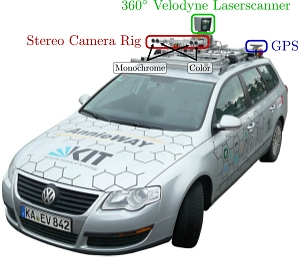

> 자율주행 보조장치 object detection 요구사항
>
> * 사람이 카메라에 감지되면 정지
> * 차량이 일정 크기 이상으로 감지되면 정지

**KITTI 데이터셋**은 **자율주행을 위한 데이터셋**으로 `2D object detection` 뿐만 아니라 깊이까지 포함한 `3D object detection` 라벨 등을 제공하고 있습니다.

In [ ]:
# 라이브러리 불러오기
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [ ]:
# 데이터 경로 설정하기
DATA_PATH = '/content/drive/MyDrive/07. GoData/11. Object Detection'

In [ ]:
# 데이터셋 불러오기
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    with_info=True,
)

우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있습니다.

In [ ]:
# 훈련용 데이터셋 확인하기
_ = tfds.show_examples(ds_train, ds_info)

In [ ]:
# 검증용 데이터셋 확인하기
_ = tfds.show_examples(ds_validation, ds_info)

In [ ]:
# 테스트용 데이터셋 확인하기
_ = tfds.show_examples(ds_test, ds_info)

오늘 사용할 데이터셋은 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다.

라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있습니다.

In [ ]:
# 데이터셋 개수 확인하기
print(tf.data.experimental.cardinality(ds_train))  # 훈련용 데이터셋
print(tf.data.experimental.cardinality(ds_validation))  # 검증용 데이터셋
print(tf.data.experimental.cardinality(ds_test))  # 테스트용 데이터셋

In [ ]:
# 데이터 정보 확인하기
ds_info.features

In [ ]:
# 데이터셋 클래스 개수 확인하기
num_classes = ds_info.features["objects"]["type"].num_classes
num_classes

In [ ]:
# 데이터셋 구성 확인하기
type_names = ds_info.features['objects']['type'].names
type_names

### **(2) 데이터 직접 확인하기**

`ds_train.take()`을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다.

이렇게 뽑은 데이터에는 `image` 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

In [ ]:
# 데이터 개수 설정하기
sp_number = 10

# 데이터 뽑아보기
sample = ds_train.take(sp_number)

In [ ]:
# 데이터의 정보 확인하기
for i, example in enumerate(sample):
    if i >= sp_number:  # 처음 10개의 예제만 확인
        break
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

    print('------objects------')
    print(objects)

    img = Image.fromarray(image.numpy())
    plt.imshow(img)
    plt.show()

이미지와 라벨을 얻는 방법을 알게 되었습니다.

위 설명과 예시 이미지를 참고해서 이미지 위에 바운딩 박스를 그려서 시각화해 봅시다.

In [ ]:
# 이미지 위에 바운딩 박스 그리는 함수 구현하기
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = input_image.size
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect.tolist(), outline=(255, 0, 0), width=2)

    return input_image

In [ ]:
# 데이터셋에서 여러 장의 이미지 시각화하기
plt.figure(figsize=(20, sp_number * sp_number))

for i, example in enumerate(sample):
  if i >= sp_number:
        break

  image = example["image"]
  objects = example["objects"]

  img = Image.fromarray(image.numpy())
  visualized_image = visualize_bbox(img, objects['bbox'].numpy())

  plt.subplot(sp_number, 1, i + 1)
  plt.imshow(visualized_image)
  plt.axis('off')
  plt.title(f'Bounding Box Results {i + 1}')

plt.show()

## **2. RetinaNet**

RetinaNet에서는 **focal loss**와 **FPN(Feature Pyramid Network)**를 적용한 네트워크를 사용합니다.

**Focal Loss**

> 물체를 배경보다 더 잘 학습하자 → 물체인 경우 Loss를 작게 만들자

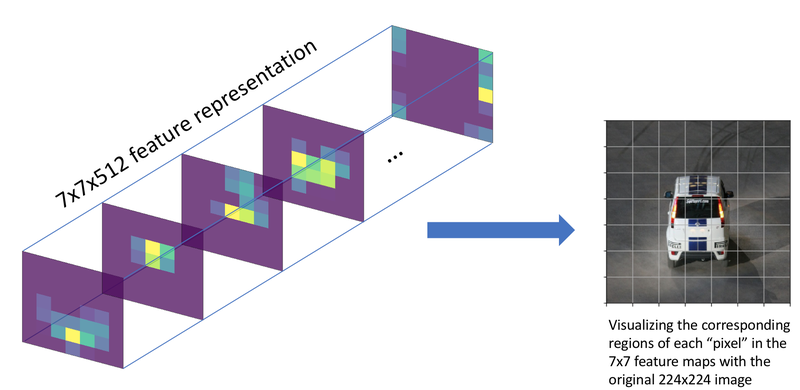

**FPN(Feature Pyramid Network)**

> 여러 층의 특성 맵(feature map)을 다 사용해보자

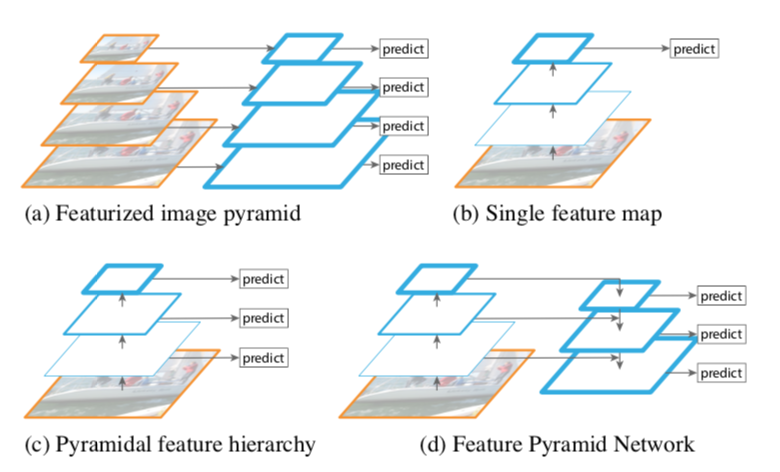

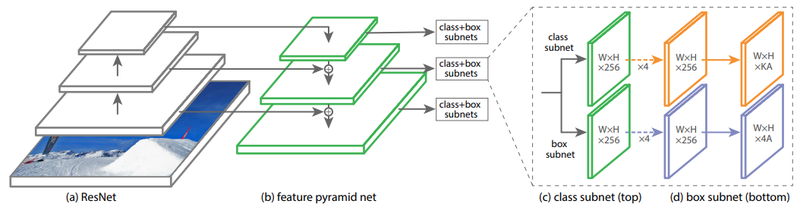

## **3. 데이터 준비**

### **데이터 파이프 라인**

주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 합니다.

이때 사용할 데이터 파이프라인을 구축합니다.

데이터 파이프라인은 총 4단계로 이루어집니다.

1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 `[x_min, y_min, x_max, y_max]`에서 `[x_min, y_min, width, height]`으로 수정

독립적인 함수를 각각 작성합니다.

In [ ]:
# x와 y좌표 위치 교체하기
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [ ]:
# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )

    return image, boxes

이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 합니다. 또한 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 `stride`의 배수가 되도록 만들어야 합니다.

실제로 입력할 이미지를 어떻게 바꿀지는 `min_side`, `max_side`, `min_side_range`, `stride` 등에 의해 결정됩니다.

In [ ]:
# 이미지 크기 조정 및 패딩 추가하기
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0

    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )

    return image, image_shape, ratio

In [ ]:
# x_max, y_max를 width, height으로 바꾸기
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

이제 준비된 함수들을 연결해 줍니다.

In [ ]:
# 데이터 전처리하기
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### **인코딩**

One stage detector에서 Anchor Box는 사전 정의된 위치, 크기, 비율로 물체 위치를 결정하며, 촘촘하게 겹쳐 생성되어 물체를 잘 찾아냅니다. RetinaNet에서는 FPN의 각 층마다 Anchor Box가 필요하고, 각 level에서 생성되는 Anchor Box 개수는 미리 정해져 있습니다.

In [ ]:
# Anchor Box 생성하기
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해줘야 합니다.

데이터 원본의 bbox는 주관식 정답인데, 모델은 객관식으로 문제를 풀어야 하기 때문에 주관식 정답을 가장 가까운 객관식 정답으로 바꿔줘야 모델을 학습시킬 수 있습니다.

IoU를 계산할 수 있는 함수를 만들어 IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크해 둘 수 있습니다.

In [ ]:
# 데이터를 Anchor Box에 맞게 변형해주기
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [ ]:
# IoU를 계산할 수 있는 함수 만들기
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

이제 실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들어 봅시다.

위에서 작성한 `compute_iou` 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 줍니다.

그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다.

상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.

마치 데이터를 훈련이 가능한 형식으로 encode하는 것 같으니 LabelEncoder라는 이름으로 클래스를 만들었습니다.

In [ ]:
# LabelEncoder 클래스 만들기
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

이제 데이터를 모델이 학습 가능한 형태로 바꿔 줄 수 있게 되었으니 모델을 만들러 가봅시다.

## **4. 모델 작성**

### **Feature Pyramid**

RetinaNet에서는 **FPN(Feature Pyramid Network)**를 사용합니다.

완전히 동일한 것은 아니고 약간 수정해서 사용했습니다.

In [ ]:
# Feature Pyramid 구성하기
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다.

Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 **class를 예상하고, box도 예상합니다.**

그래서 각각의 head를 만들어 줍니다. head 부분은 유사한 형태로 만들 수 있으니 `build_head`라는 함수를 하나만 만들고 두 번 호출하면 됩니다.

In [ ]:
# build head 함수 구현하기
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

우리가 만들 RetinaNet의 backbone은 ResNet50입니다.

FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다.

In [ ]:
# 백본 함수 만들기(ResNet50)
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

이제 RetinaNet을 완성해 봅시다.

Backbone + FPN + classification용 head + box용 head 입니다.

In [ ]:
# RetinaNet 완성하기 (Backbone + FPN + classification용 head + box용 head)
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

RetinaNet에서는 `Focal Loss`를 사용합니다.

Box Regression에는 사용하지 않고 **Classification Loss**를 계산하는데만 사용됩니다.

**Box Regression**에는 `Smooth L1 Loss`를 사용했습니다.

In [ ]:
# RetinaNetBoxLoss 구현하기
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)

In [ ]:
# RetinaNetClassificationLoss 구현하기
class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

In [ ]:
# RetinaNetLoss 구현하기
class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

이제 모든 준비가 끝났습니다. 모델 학습을 할 수 있습니다.

## **5. 모델 학습**

앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습시켜 봅시다.

In [ ]:
# 배치 사이즈 설정하기
batch_size = 2

In [ ]:
# 백본, 손실률, 모델 정의한 것 불러오기
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

모델은 매우 간단하게 만들어 졌습니다.

논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않아, Learning Rate를 적절히 바꿔줍니다.

Optimizer는 동일하게 SGD를 사용합니다.

In [ ]:
# learning_rate 설정하기
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

In [ ]:
# optimizer 설정하기
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn,
                              momentum=0.9)

In [ ]:
# 모델 컴파일하기
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=["accuracy"])

이제 데이터 전처리를 위한 파이프라인도 만들어 줍니다.

In [ ]:
# LabelEncoder 적용하기
label_encoder = LabelEncoder()

In [ ]:
# 모델 전처리를 위한 데이터 파이프라인 만들기
autotune = tf.data.AUTOTUNE

(ds_train, ds_validation), ds_info = tfds.load(
                                      "kitti",
                                      split=["train", "validation"],
                                      with_info=True,
                                      data_dir=DATA_PATH
                                  )

autotune = tf.data.AUTOTUNE

# 훈련 데이터셋 전처리하기
ds_train = ds_train.map(preprocess_data, num_parallel_calls=autotune)
ds_train = ds_train.shuffle(8 * batch_size)
ds_train = ds_train.padded_batch(
    batch_size=batch_size,
    padding_values=(0.0, 1e-8, -1),
    drop_remainder=True
)
ds_train = ds_train.map(
    label_encoder.encode_batch,
    num_parallel_calls=autotune
)
ds_train = ds_train.prefetch(autotune)

# 검증 데이터셋 전처리하기
ds_validation = ds_validation.map(preprocess_data,
                                  num_parallel_calls=autotune)
ds_validation = ds_validation.padded_batch(
    batch_size=batch_size,
    padding_values=(0.0, 1e-8, -1),
    drop_remainder=True
)
ds_validation = ds_validation.map(label_encoder.encode_batch,
                                  num_parallel_calls=autotune)
ds_validation = ds_validation.prefetch(autotune)

학습을 위한 콜백 함수를 불러옵니다.

In [ ]:
# 학습 횟수 설정하기
# epochs = 30

In [ ]:
# 모델 체크포인트 불러오기
'''
model_dir = '/content/drive/MyDrive/07. GoData/11. Object Detection/checkpoints'
'''

In [ ]:
# callback 함수 불러오기
'''
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )
]
'''

In [ ]:
# EarlyStopping 사용하기
'''
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

# callback 함수에 earlystopping 추가하기
callbacks_list.append(early_stopping)
'''

In [ ]:
# 학습 과정 저장하기
'''
retina_model = model.fit(
    ds_train,
    validation_data=ds_validation,
    epochs=epochs,
    callbacks= callbacks_list
)
'''

In [ ]:
# 학습 결과 저장하기
# history_retina_model = retina_model

In [ ]:
# history 객체로부터 데이터 추출하기
'''
def draw_history(history):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()
  '''

In [ ]:
# 학습 결과 시각화하기
# draw_history(history_retina_model)

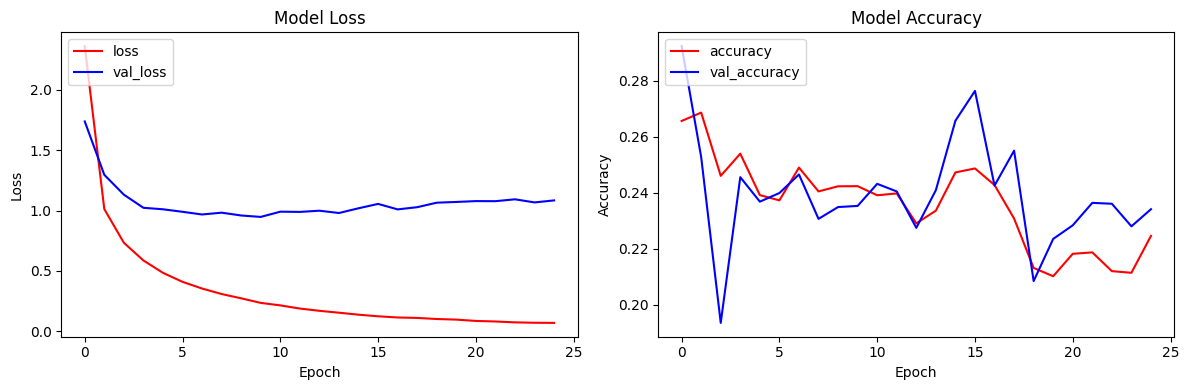

In [ ]:
# 학습한 모델 저장하기
'''
model.save_weights(model_path)
print('Complete Saving RetinaNet Model')
'''

## **6. 결과 불러오기**

학습된 모델을 불러옵시다.

In [ ]:
# 모델 체크포인트 불러오기
model_dir = '/content/drive/MyDrive/07. GoData/11. Object Detection/checkpoints'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 줍니다.

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 `tf.image.combined_non_max_suppression`를 사용했습니다.

특히 출력에 `nmsed_boxes`, `nmsed_scores`, `nmsed_classes`, `valid_detections`이 각각 무엇인지 알아야 활용할 수 있습니다.

In [ ]:
# 디코딩된 예측 출력하기
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

추론이 가능한 모델을 조립합니다.

In [ ]:
# 추론 가능한 모델 모으기
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

모델의 추론 결과를 시각화 할 함수를 만들어 줍니다.

In [ ]:
# 차와 사람 리스트 만들기
car_list = ['Car', 'Van', 'Truck', 'Tram', 'Misc']
people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']

In [ ]:
# 모델의 추론 결과를 시각화 할 함수 만들기
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 4),
    linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)

    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):

        if _cls in car_list:
            color=[0,1,1]  # 객체가 차량일 경우, 하늘색 설정하기
        elif _cls in people_list:
            color = [1,1,0]  # 객체가 사람일 경우, 노란색 설정하기

        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        # matplitlib에서 Rectangle와 text를 그릴 때는
        # 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        origin_x, origin_y = x1, image.shape[0] - y2
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False,
            edgecolor=color,
            linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

이제 추론시에 입력 데이터를 전처리하기 위한 함수를 만들어 봅시다.

학습을 위한 전처리와 추론을 위한 전처리가 다르기 때문에 따로 작성됩니다.

In [ ]:
# 추론을 위한 전처리 함수 작성하기
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

In [ ]:
# object_detection 결과 가져오기
def get_object_detection_result(image):
    int2str = ds_info.features["objects"]["type"].int2str

    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    scores = detections.nmsed_scores[0][:num_detections]

    return image, boxes, class_names, scores

In [ ]:
# object_detection 결과 시각화하기
for sample in ds_test.take(20):
    visualize_detections(*get_object_detection_result(sample["image"]))

## **7. 자율주행 시스템 만들기**

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어야 합니다.

* 입력으로 이미지 경로를 받습니다.
* 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
* 조건은 다음과 같습니다.
    * 사람이 한 명 이상 있는 경우
    * 차량의 크기(width or height)가 300px이상인 경우

In [ ]:
# 미니 자율주행 시스템 만드는 함수 구현하기
def self_drive_assist(image_path,
                      size_limit=300,
                      to_visualize=False,
                      people_list = ['Pedestrian',
                                     'Person_sitting',
                                     'Cyclist']):
    # 이미지 전처리하기
    image = Image.open(image_path).convert('RGB')
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image, boxes, class_names, scores = get_object_detection_result(image)

    # 시각화하기
    if to_visualize:
        visualize_detections(image, boxes, class_names, scores)

    # 정지조건 1: 사람 한 명 이상 있는 경우 "Stop"
    if len(set(class_names) & set(people_list)) > 0:
        return "Stop"

    # 정지조건 2: 차량 크기(W,H)가 300px 이상인 경우 "Stop"
    for box, class_name, score in zip(boxes, class_names, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        # print(f"w {w:.2f}, h {h:.2f}, w*h {w*h:.2f}")  # 자동차 크기 출력하기
        if w >= size_limit or h >= size_limit:
            return "Stop"

    # 아니면 "Go"
    return "Go"

In [ ]:
# 데이터 경로 설정하기
self_driving_path = os.path.join(DATA_PATH, 'self_driving_images')

In [ ]:
# 이미지 경로 설정하기
image_path_list = [image_path for image_path in os.listdir(self_driving_path)
                    if image_path.endswith('.png')]

In [ ]:
# 이미지 자율주행 시스템 결과 확인하기
for i, image_path in enumerate(image_path_list):
    print(i, image_path)
    print(self_drive_assist(os.path.join(self_driving_path, image_path),
                            size_limit=300,
                            to_visualize=True))
    print('━━━━━━━━━━━━━━━')

In [ ]:
# LA driving 데이터 경로 설정하기
driving_path = os.path.join(DATA_PATH, 'driving')

In [ ]:
# 이미지 크기 조정 함수
def resize_image(image_path, target_width=1280, target_height=720):
    with Image.open(image_path) as img:
        width, height = img.size
        if width > target_width or height > target_height:
            img.thumbnail((target_width, target_height), Image.LANCZOS)
            resized_image_path = os.path.splitext(image_path)[0] + "_resized.png"
            img.save(resized_image_path, format='PNG')
            return resized_image_path
        else:
            return image_path

In [ ]:
# LA driving 이미지 자율주행 시스템 결과 확인하기(LA의 낮 사진)
day_LA_path = os.path.join(driving_path, 'day')

# 이미지 경로 설정하기
day_image_path_list = [os.path.join(day_LA_path, image_path)
                       for image_path in os.listdir(day_LA_path)
                       if image_path.endswith('.png')]

# 각 이미지를 처리하고 시각화하기
for i, image_path in enumerate(day_image_path_list):
    try:
        # 이미지 크기 조정하기
        resized_image_path = resize_image(image_path, target_width=1280, target_height=720)

        # 자율주행 보조 시스템 실행하기
        print(f"Processing image {i}: {resized_image_path}")
        result = self_drive_assist(resized_image_path, to_visualize=True)
        print(result)
        print('━━━━━━━━━━━━━━━')
    except Exception as e:
        print(f"Error processing image {i}: {image_path}")
        print(f"Error: {e}")
        print('━━━━━━━━━━━━━━━')

In [ ]:
# LA driving 이미지 자율주행 시스템 결과 확인하기(LA의 밤 사진)
night_LA_path = os.path.join(LA_driving_path, 'night')

# 이미지 경로 설정하기
night_image_path_list = [os.path.join(night_LA_path, image_path)
                       for image_path in os.listdir(night_LA_path)
                       if image_path.endswith('.png')]

# 각 이미지를 처리하고 시각화하기
for i, image_path in enumerate(night_image_path_list):
    try:
        # 이미지 크기 조정하기
        resized_image_path = resize_image(image_path,
                                          target_width=1280,
                                          target_height=720)

        # 자율주행 보조 시스템 실행하기
        print(f"Processing image {i}: {resized_image_path}")
        result = self_drive_assist(resized_image_path, to_visualize=True)
        print(result)
        print('━━━━━━━━━━━━━━━')
    except Exception as e:
        print(f"Error processing image {i}: {image_path}")
        print(f"Error: {e}")
        print('━━━━━━━━━━━━━━━')

## **8. 자율주행 시스템 평가하기**

아래 `test_system()`를 통해서 위에서 만든 함수를 평가해봅시다.

테스트 이미지를 통해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [ ]:
# 자율주행 시스템 평가하는 함수 구현하기
def test_system(func, data_dir):
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = os.path.join(data_dir, image_file)
        pred = func(image_path)
        if pred == answer:
            score += 10
        print(f'pred: {pred}, answer: {answer}, score: {score}')

    print(f"\n***** {score}점입니다. *****")

In [ ]:
# 미니 자율주행 시스템 평가하기
test_system(self_drive_assist, self_driving_path)

# **2. 회고하기**

**[배운 점 & 느낀 점]**  평소에 자율주행과 object detection 분야에 관심은 있었지만, 어떻게 공부해야 하는지 갈피를 못잡고 있었는데, 이번 기회를 통해 전반적인 작동 방식에 대해 공부해서 좋았다. 특히 추가 실험을 하는 과정이 제대로 작동하지는 않았지만, 결과를 볼 수 있는 것 같아서 재밌었다. 이 시간 이후로도 한번 더 실험해보고 싶다.

**[어려웠던 점 & 아쉬웠던 점]** 가장 어려웠던 점은 추가로 LA의 낮/저녁/밤의 이미지를 유튜브에서 프레임 단위로 잘라서 추가 실험을 진행할 때였다. 사진의 크기 때문인지, 혹은 해상도 문제인지는 모르겠는데, 정확히 물체 탐지를 하지 못한다는 것이었다. 또한 여러 실험을 진행해보면서, 더 많은 물체 탐지 조건이 있을텐데, 단지 사람과 차를 구분하고 멈추고 가는 것으로는 성에 차지 않았다. 또한 YOLO를 많이 공부했었는데, 이를 적용하지 못한 것 같아서 많이 아쉽다.